In [82]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    log_loss,
    roc_auc_score,
    precision_score,
    recall_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold
import numpy as np 
import pandas as pd 
from sklearn.model_selection import RandomizedSearchCV
import plotly
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from IPython.display import display, Image
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline,make_pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import pickle

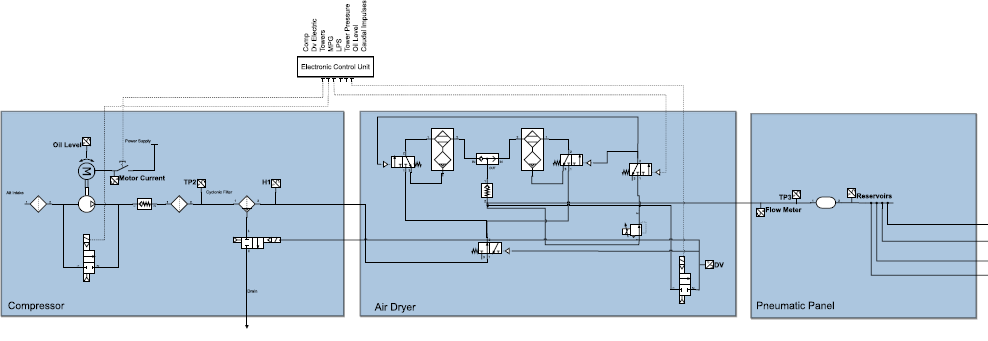

In [193]:
display(Image(filename="Esquema.png"))

### El conjunto de datos consta de 1.516.480 puntos de datos recopilados a 1 Hz de febrero a agosto de 2020 y se describe mediante 15 características de 7 sensores analógicos (1-7) y 8 digitales (8-15):

#### <u>APU</u>= Compresor
##### 1. <u>TP2 (bar)</u> : la medida de la presión en el compresor.
##### 2. <u>TP3 (bar):</u> la medida de la presión generada en el panel neumático.
##### 3. <u>H1 (bar):</u> la medida de la presión generada debido a la caída de presión cuando se descarga el separador ciclónico.
##### 4. <u>Presión DV (bar):</u> la medida de la caída de presión generada cuando las torres descargan los secadores de aire; una lectura 0 indica que el compresor está funcionando bajo carga.
##### 5. <u>Reservorios (bar):</u> la medida de la presión aguas abajo de los reservorios, que debe estar cerca de la presión del panel neumático (TP3).
##### 6. <u>Corriente del motor (A):</u> la medida de la corriente de una fase del motor trifásico; presenta valores cercanos a 0A - cuando se apaga, 4A - cuando funciona descargado, 7A - cuando trabaja bajo carga y 9A - cuando arranca.
##### 7. <u>Temperatura del aceite (ºC):</u> la medida de la temperatura del aceite en el compresor.
##### 8. <u>COMP:</u> La señal eléctrica de la válvula de entrada de aire en el compresor; está activo cuando no hay entrada de aire,
##### indicando que el compresor está apagado o funcionando en estado descargado.
##### 9. <u>DV eléctric:</u> la señal eléctrica que controla la válvula de salida del compresor; está activo cuando el compresor está
##### funcionando bajo carga e inactivo cuando el compresor está apagado o funcionando en estado descargado.
##### 10. <u>Torres:</u> La señal eléctrica que define la torre responsable de secar el aire y la torre responsable
##### para drenar la humedad extraída del aire; cuando no está activo indica que la torre uno está funcionando; cuando
##### activo, indica que la torre dos está en funcionamiento.
##### 11. <u>MPG:</u> la señal eléctrica responsable de arrancar el compresor bajo carga activando la válvula de admisión.
##### Cuando la presión en la unidad de producción de aire (APU) cae por debajo de 8,2 bar; activa el sensor COMP, que asume
##### el mismo comportamiento que el sensor MPG.
##### 12. <u>LPS:</u> la señal eléctrica que detecta y se activa cuando la presión cae por debajo de 7 bares.
##### 13. <u>Presostato:</u> la señal eléctrica que detecta la descarga en las torres de secado de aire.
##### 14. <u>Nivel de aceite:</u> la señal eléctrica que detecta el nivel de aceite en el compresor; está activo cuando el aceite está por debajo de valores esperados.
##### 15. <u>Pulsos de caudal:</u> la señal eléctrica que cuenta las salidas de pulso generadas por la cantidad absoluta de aire que fluye desde la APU a los reservorios.

### <u>Objetivo</u>: Predecir una falla ocasionada por pérdida de aire en el circuito neumático con anticipación de 5 días.

### Definición de funciones

In [83]:
def feature_importance (modelo,X_train):
    feature_importance = modelo.feature_importances_


    std = np.std([tree.feature_importances_ for tree in modelo.estimators_], axis=0)

    feature_names = X_train.columns

    data_to_plot = pd.DataFrame(columns = ['feature', 'importance', 'error'])

    for i in range(len(feature_importance)):
        data_to_plot = data_to_plot.append({'feature': feature_names[i],
                                            'importance': feature_importance[i],
                                            'error': std[i]
                                           }, ignore_index=True)    

    data_to_plot.sort_values(by = 'importance', axis=0, ascending=False, inplace=True)
    plt.figure()
    plt.title("Importancia de los features en RandomForest")
    x_values = range(data_to_plot.shape[0])
    y_values = data_to_plot.importance
    y_err = data_to_plot.error
    plt.bar(x_values, y_values, color="r", align="center", yerr=y_err )
    plt.xticks(x_values, data_to_plot.feature, rotation=90)
    plt.show()
    return

In [84]:
def predecir_falla (y_pred,X_test):
    indices_positivos = np.where(y_pred == 1)[0]
    registros_positivos = df_after_split.iloc[indices_positivos]
    registros_ordenados=registros_positivos.timestamp.value_counts()[0:2].sort_values(ascending=False)
    return print(f'El tren fallará el día {registros_ordenados.index[0].date() + timedelta(days=1)} por una pérdida de aire en algún lugar del circuito neumático.')

In [85]:

def modificar_threshold( modelo,X_test,y_test,threshold):
    y_proba = modelo.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    cr=classification_report(y_test, y_pred)
    print("Matriz de confusión")
    print(cm)
    print("Reporte de clasificación")
    print(cr)
    return y_pred,cm 

In [86]:
def modelos_ensamble (X_train,X_test,y_train,y_test,modelo,params):
    
    folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
    randomized= RandomizedSearchCV(modelo,param_distributions=params, cv=folds, verbose=1, n_jobs=-1,n_iter=3)
    
    randomized.fit(X_train,y_train)
    y_pred = randomized.best_estimator_.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred )
    cr=classification_report(y_test, y_pred)
    
    print("Best score: %0.3f" % randomized.best_score_) 
    print("Best parameters set:" )
    best_parameters = randomized.best_estimator_.get_params()
    for param_name in sorted (params.keys()): 
                    print("\t %s: %r" % (param_name, best_parameters[param_name])) 
      
    
    print(cr)
    print("Matriz de Confusión: ")
    print(cm)
    print("Accuracy= ", accuracy_score(y_test, y_pred))
    
    return randomized.best_estimator_

In [87]:
def violin_plot(variable_1,variable_2,Fecha_comienzo,Fecha_fin):

    Fecha_comienzo = Fecha_comienzo
    Fecha_fin= Fecha_fin
    df_filtrado = metro_df_grande[(metro_df_grande.timestamp>= Fecha_comienzo) & (metro_df_grande.timestamp<= Fecha_fin)]
    plt.figure(figsize=(4, 4))
    sns.violinplot(data=df_filtrado[[variable_1, variable_2]], palette='muted', split=True)

    # Añadir título y etiquetas a los ejes
    plt.title('Comparación de Variables con Violin Plot')
    plt.xlabel('Variable')
    plt.ylabel('Valor (bar)')

    # Mostrar el gráfico
    plt.show()
    return

In [88]:
def comparacion_medias(variable,df_sin_fallas,df_con_fallas):
    print(f'Media de {variable} en condiciones normales = {round(df_sin_fallas[variable].mean(), 2)}')
    print(f'Media de {variable} en periodo previo a las fallas = {round(df_con_fallas[variable].mean(), 2)}')
    
    return

In [89]:
def comparacion_ratios(variable,df_sin_fallas,df_con_fallas):
    ratio_pos_condiciones_normales=round(df_sin_fallas[variable].value_counts()[1]/df_sin_fallas[variable].value_counts()[0],2)
    ratio_pos_previo_falla=round(df_con_fallas[variable].value_counts()[1]/df_con_fallas[variable].value_counts()[0],2)
    print(f'Ratio positivo de {variable} condiciones normales = {round(df_sin_fallas[variable].value_counts()[1]/df_sin_fallas[variable].value_counts()[0],2)}')
    print(f'Ratio positivo de {variable} en periodo previo a las fallas = {round(df_con_fallas[variable].value_counts()[1]/df_con_fallas[variable].value_counts()[0],2)}')
    return ratio_pos_condiciones_normales,ratio_pos_previo_falla

In [90]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(X[self.columns])
        else:
            raise TypeError("Este Transformador solo funciona en DF de Pandas")
    
    def fit(self, X, *_):
        return self

In [91]:
def numerical_columns_pipe(numerical_columns_list):
    numerical_pipe=make_pipeline(ColumnSelector(numerical_columns_list),StandardScaler())
    return numerical_pipe

def categorical_columns_pipe(categorical_columns_list):
    categorical_pipe= make_pipeline(ColumnSelector(categorical_columns_list))
    return categorical_pipe


In [92]:
def modelo_con_pipe(X_train,X_test,y_train,y_test,descripcion_modelo,modelo,numerical_pipe,categorical_pipe,params):
    union = make_union(numerical_pipe,
                   categorical_pipe)
    pipeline = Pipeline([('union', union), 
                     (descripcion_modelo,modelo)])
    
    folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
    randomized= RandomizedSearchCV(modelo,param_distributions=params, cv=folds, verbose=1, n_jobs=-1,n_iter=3)
    
    randomized.fit(X_train,y_train)
    y_pred = randomized.best_estimator_.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred )
    cr=classification_report(y_test, y_pred)
    
    print("Best score: %0.3f" % randomized.best_score_) 
    print("Best parameters set:" )
    best_parameters = randomized.best_estimator_.get_params()
    for param_name in sorted (params.keys()): 
                    print("\t %s: %r" % (param_name, best_parameters[param_name])) 
      
    
    print(cr)
    print("Matriz de Confusión: ")
    print(cm)
    print("Accuracy= ", accuracy_score(y_test, y_pred))
    
    return randomized.best_estimator_


In [93]:
def ratio_3_dias(merged_df, variable):
    # Crear columnas de acumuladores para unos y ceros
    merged_df['ones'] = (merged_df[variable] == 1).astype(int)
    merged_df['zeros'] = (merged_df[variable] == 0).astype(int)
    
    # Calcular las sumas acumulativas
    merged_df['ones_cumsum'] = merged_df['ones'].cumsum()
    merged_df['zeros_cumsum'] = merged_df['zeros'].cumsum()
    
    # Calcular las sumas en la ventana de 3 días
    merged_df['ones_window'] = merged_df['ones_cumsum'] - merged_df['ones_cumsum'].shift(3, fill_value=0)
    merged_df['zeros_window'] = merged_df['zeros_cumsum'] - merged_df['zeros_cumsum'].shift(3, fill_value=0)
    
    # Calcular el ratio
    ratio_column_name = f'ratio_positivos_{variable}_3dias'
    merged_df[ratio_column_name] = merged_df['ones_window'] / (merged_df['zeros_window'] + 1e-5)
    
    # Ajustar valores extremos
    merged_df.loc[merged_df[ratio_column_name] > 100, ratio_column_name] = 0
    
    # Eliminar columnas temporales
    merged_df.drop(columns=['ones', 'zeros', 'ones_cumsum', 'zeros_cumsum', 'ones_window', 'zeros_window'], inplace=True)
    
    return 

In [94]:
def ratio_1_dia(merged_df, variable):   
    merged_df['ones'] = (merged_df[variable] == 1).astype(int)
    merged_df['zeros'] = (merged_df[variable] == 0).astype(int)
    
    # Desplazar las columnas para obtener el valor anterior
    merged_df['ones_shift'] = merged_df['ones'].shift(1, fill_value=0)
    merged_df['zeros_shift'] = merged_df['zeros'].shift(1, fill_value=0)
    
    # Calcular el ratio
    ratio_column_name = f'ratio_positivos_{variable}_1dia'
    merged_df[ratio_column_name] = merged_df['ones'] / (merged_df['zeros_shift'] + 1e-5)
    
    # Ajustar valores extremos
    merged_df.loc[merged_df[ratio_column_name] > 100, ratio_column_name] = 0
    
    # Eliminar columnas temporales
    merged_df.drop(columns=['ones', 'zeros', 'ones_shift', 'zeros_shift'], inplace=True)
    
    return 

In [95]:
def filtro_fallas(merged_df, fechas_falla,weeks):
    filtro = pd.Series([False] * len(merged_df))
    for fecha in fechas_falla:
        inicio = fecha - pd.Timedelta(weeks=weeks)
        filtro = filtro | ((merged_df['timestamp'] >= inicio) & (merged_df['timestamp'] <= fecha))
    return filtro

### Limpieza y exploración de datos

In [96]:
metro_df_grande=pd.read_csv("MetroPT3(AirCompressor).csv",sep=",")
metro_df_grande.head()


,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,10,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,20,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3,30,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4,40,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [97]:
metro_df_grande.drop(columns="Unnamed: 0",inplace=True)

In [98]:
metro_df_grande['timestamp'] = pd.to_datetime(metro_df_grande['timestamp']).dt.floor('D')

In [99]:
metro_df_grande.shape

(1516948, 16)

### Importamos el archivo de fallas, de acá va a salir nuestra variable objetivo, que es realizar una predicción de la falla por pérdida de aire.

In [100]:
fallas=pd.read_csv("Fallas.csv",sep=",")
fallas

,Failure Number,Start Time,End Time,Failure Type,Severity,Report
0,1,4/18/2020 0:00,4/18/2020 23:59,Air leak,High Stress,NaN
1,2,5/29/2020 23:30,5/30/2020 6:00,Air leak,High Stress,Maintenance on 4/30/2020 12:00
2,3,6/05/2020 10:00,6/07/2020 14:30,Air leak,High Stress,Maintenance on 6/08/2020 16:00
3,4,7/15/2020 14:30,7/15/2020 19:00,Air leak,High Stress,Maintenance on 7/16/2020 00:00


### Quitamos las horas de la variable start time, para simplificar la lectura.

In [101]:
fallas['Start Time'] = pd.to_datetime(fallas['Start Time']).dt.floor('D')
fallas['End Time'] = pd.to_datetime(fallas['End Time']).dt.floor('D')

### Generamos un dataframe con los días anteriores a la detección de la falla. Se toman 3 dias hacia atras.

In [102]:
# Iteramos sobre cada fecha del DataFrame original
fechas_expandidas = []
for fecha in fallas['Start Time']:
    # Generamos un rango de fechas desde la fecha hasta 3 días antes
    rango_fechas = pd.date_range(end=fecha-timedelta(days=1), periods=5, freq='D')
    # Agregamos estas fechas al listado de fechas expandidas
    fechas_expandidas.extend(rango_fechas)

# Creamos un nuevo DataFrame con las fechas expandidas
fallas_dias_anteriores = pd.DataFrame({'Fallas_semana_anterior': fechas_expandidas})
fallas_dias_anteriores

,Fallas_semana_anterior
0,2020-04-13
1,2020-04-14
2,2020-04-15
3,2020-04-16
4,2020-04-17
5,2020-05-24
6,2020-05-25
7,2020-05-26
8,2020-05-27
9,2020-05-28


In [103]:
fechas_expandidas = []
for fecha in fallas['End Time']:
    # Generamos un rango de fechas que incluyan la falla.
    rango_fechas = pd.date_range(end=fecha, periods=1, freq='D')
    # Agregamos estas fechas al listado de fechas expandidas
    fechas_expandidas.extend(rango_fechas)

# Creamos un nuevo DataFrame con las fechas expandidas
fallas_dia_falla = pd.DataFrame({'Fallas_dia_falla': fechas_expandidas})
fallas_dia_falla

,Fallas_dia_falla
0,2020-04-18
1,2020-05-30
2,2020-06-07
3,2020-07-15


### Unimos el dataset con los dos dataframes creados con las fechas anteriories a la falla, de manera que tenemos una columna que se "enciende" para todos los registros de dos días antes a cada falla.

In [104]:
merged_df = pd.merge_asof(metro_df_grande, fallas_dia_falla, left_on='timestamp', right_on='Fallas_dia_falla',tolerance=pd.Timedelta(hours=6))

merged_df = pd.merge_asof(merged_df, fallas_dias_anteriores, left_on='timestamp', right_on='Fallas_semana_anterior',tolerance=pd.Timedelta(hours=6))


In [105]:
merged_df["Fallas_semana_anterior"].value_counts()

2020-06-04    8716
2020-06-01    8523
2020-05-28    8436
2020-04-15    8433
2020-04-16    8027
2020-06-03    7976
2020-07-13    7434
2020-05-31    7294
2020-07-10    7157
2020-05-27    7096
2020-05-25    6902
2020-04-14    6329
2020-04-17    6301
2020-07-12    5609
2020-05-26    5606
2020-07-11    5253
2020-06-02    5131
2020-07-14    3563
2020-04-13    3501
2020-05-24     210
Name: Fallas_semana_anterior, dtype: int64

In [106]:
merged_df["Fallas_dia_falla"].value_counts()

2020-04-18    8663
2020-07-15    8661
2020-05-30    8617
2020-06-07    4888
Name: Fallas_dia_falla, dtype: int64

### Transformamos la columna en nuestra variable objetivo, con valores 1 y 0 como posibles. Lo que buscaremos predecir es si un registro indica que el equipo tiene  máximo 2 días hasta averiarse.

In [107]:
merged_df['Fallas_dia_falla'] = merged_df['Fallas_dia_falla'].notnull().astype(int)
merged_df['Fallas_semana_anterior'] = merged_df['Fallas_semana_anterior'].notnull().astype(int)


In [108]:
merged_df['Fallas_semana_anterior'].value_counts()

0    1389451
1     127497
Name: Fallas_semana_anterior, dtype: int64

In [109]:
merged_df['Fallas_dia_falla'].value_counts()

0    1486119
1      30829
Name: Fallas_dia_falla, dtype: int64

### Generamos un dataframe en condiciones normales y con fallas para analizar las diferencias entre variables.

In [110]:
sin_fallas_mask = merged_df['Fallas_semana_anterior'] == 0
df_sin_fallas = merged_df[sin_fallas_mask]

In [111]:
df_con_fallas = merged_df[~sin_fallas_mask]


In [112]:
sin_fallas_mask_dia = merged_df['Fallas_dia_falla'] == 0
df_sin_fallas_dia = merged_df[sin_fallas_mask_dia]

In [113]:
df_con_fallas_dia = merged_df[~sin_fallas_mask_dia]

### Análisis de variables


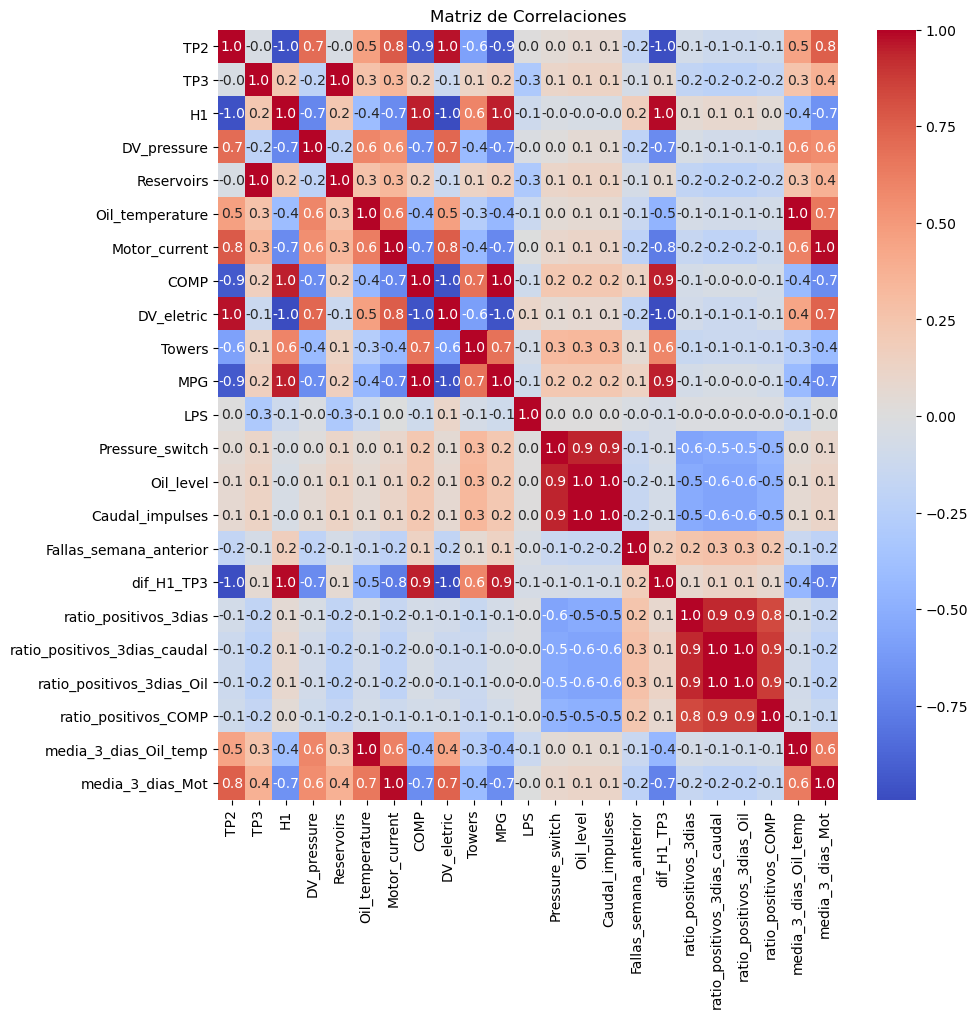

In [673]:
matriz_correlaciones = df_filtrado.corr()

# Creamos un heatmap utilizando Seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(matriz_correlaciones, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Matriz de Correlaciones')
plt.show()

#### Eliminamos una de cada par de variables que esten altamente correlacionadas para evitar sobrecargar el modelo. 
#### Estas son:  
#### TP3 con reservoirs. (Ambas miden en bares). Eliminamos reservoirs.
#### MPG y COMP (Ambas son switches). Eliminamos MPG.


### Vemos la similitud entre ambas variables

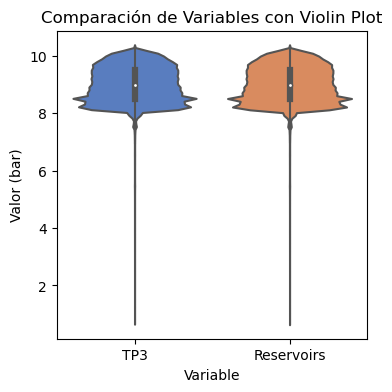

In [674]:
violin_plot("TP3","Reservoirs",'2020-03-01','2020-08-30')

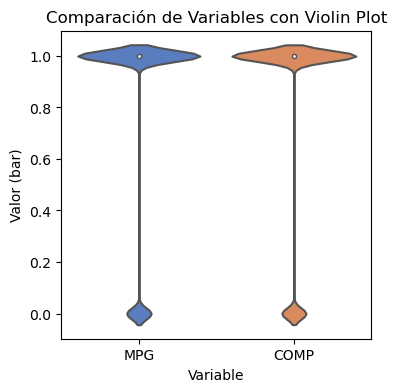

In [675]:
violin_plot("MPG","COMP",'2020-02-01','2020-09-30')

### Analizamos el promedio y el ratio de las variables booleanas en distintos períodos previos a la falla vs condiciones normales.

#### Primero con el día de la falla

In [114]:
comparacion_medias('Oil_temperature',df_sin_fallas_dia,df_con_fallas_dia)

Media de Oil_temperature en condiciones normales = 62.43
Media de Oil_temperature en periodo previo a las fallas = 72.81


In [115]:
comparacion_medias('Motor_current',df_sin_fallas_dia,df_con_fallas_dia)

Media de Motor_current en condiciones normales = 2.0
Media de Motor_current en periodo previo a las fallas = 4.5


In [116]:
comparacion_medias('TP2',df_sin_fallas_dia,df_con_fallas_dia)

Media de TP2 en condiciones normales = 1.28
Media de TP2 en periodo previo a las fallas = 5.63


In [117]:
comparacion_ratios('Oil_level',df_sin_fallas_dia,df_con_fallas_dia)

Ratio positivo de Oil_level condiciones normales = 9.23
Ratio positivo de Oil_level en periodo previo a las fallas = 452.37


(9.23, 452.37)

In [118]:
comparacion_ratios('Pressure_switch',df_sin_fallas_dia,df_con_fallas_dia)

Ratio positivo de Pressure_switch condiciones normales = 114.61
Ratio positivo de Pressure_switch en periodo previo a las fallas = 227.36


(114.61, 227.36)

### Hacemos las comparaciones para varios dias antes.

#### No se observa elevación de temperatura del aceite.

In [119]:
comparacion_medias('Oil_temperature',df_sin_fallas,df_con_fallas)

Media de Oil_temperature en condiciones normales = 62.6
Media de Oil_temperature en periodo previo a las fallas = 63.12


#### La corriente del motor parece disminuir.

In [120]:
comparacion_medias('Motor_current',df_sin_fallas,df_con_fallas)

Media de Motor_current en condiciones normales = 2.08
Media de Motor_current en periodo previo a las fallas = 1.76


In [121]:
comparacion_medias('TP2',df_sin_fallas,df_con_fallas)

Media de TP2 en condiciones normales = 1.4
Media de TP2 en periodo previo a las fallas = 0.99


#### La señal de oil_level se pone en 1 cuando el nivel de aceite es bajo, comparando los ratios de positividad vemos que la semana previa a la falla el ratio aumento considerablemente. Es una buena variable predictora.

In [122]:
comparacion_ratios('Oil_level',df_sin_fallas,df_con_fallas)

Ratio positivo de Oil_level condiciones normales = 8.79
Ratio positivo de Oil_level en periodo previo a las fallas = 35.79


(8.79, 35.79)

#### No se observan aumentos en los ratios del switch.

In [123]:
comparacion_ratios('COMP',df_sin_fallas,df_con_fallas)

Ratio positivo de COMP condiciones normales = 5.07
Ratio positivo de COMP en periodo previo a las fallas = 5.97


(5.07, 5.97)

#### La señal de LPS se activa cuando la presión baja de los 7 bares, una pérdida de aire puede aumentar el ratio positivo de este parametro. No se ven modificaciones.

In [124]:
comparacion_ratios('LPS',df_sin_fallas,df_con_fallas)

Ratio positivo de LPS condiciones normales = 0.0
Ratio positivo de LPS en periodo previo a las fallas = 0.01


(0.0, 0.01)

#### La señal positiva nos indica un mayor funcionamiento de la torre de secado de aire número 2. El funcionamiento de este equipo no da evidencias de que pueda estar relacionado a la variable objetivo a simple vista. 

In [125]:
comparacion_ratios('Towers',df_sin_fallas,df_con_fallas)

Ratio positivo de Towers condiciones normales = 11.55
Ratio positivo de Towers en periodo previo a las fallas = 10.71


(11.55, 10.71)

#### El pressure_switch se apaga con la activación de los secadores. Una disminución de ratio positivo indica un mayor funcionamiento del compresor, lo cual puede estar ocurriendo para suplir una pérdida de aire.

In [126]:
comparacion_ratios('Pressure_switch',df_sin_fallas,df_con_fallas)

Ratio positivo de Pressure_switch condiciones normales = 147.95
Ratio positivo de Pressure_switch en periodo previo a las fallas = 33.82


(147.95, 33.82)

#### El switch positivo de Caudal_impulses indica flujo de aire hacia los reservorios. Se observa un aumento de flujo de aire, lo que puede indicar mayor trabajo del compresor para suplir pérdidas.

In [127]:
comparacion_ratios('Caudal_impulses',df_sin_fallas,df_con_fallas)

Ratio positivo de Caudal_impulses condiciones normales = 14.11
Ratio positivo de Caudal_impulses en periodo previo a las fallas = 35.79


(14.11, 35.79)

### Feature engineering

##### Creamos nuevas variables que son combinaciones de las demas

In [128]:
merged_df["dif_H1_TP3"]=merged_df["H1"]-merged_df["TP3"]

##### Cálculo de los ratios con horizonte de 3 días hacia atras.

In [129]:
ratio_3_dias(merged_df,"Pressure_switch")


In [130]:
ratio_3_dias(merged_df,"Caudal_impulses")

In [131]:
ratio_3_dias(merged_df,"Oil_level")

In [132]:
ratio_3_dias(merged_df,"COMP")

### Cálculo de promedios moviles con ventanas de 3 días

In [133]:
merged_df['media_3_dias_Oil_temp'] =merged_df['Oil_temperature'].rolling(window=3).mean()

In [134]:
merged_df['media_3_dias_Mot'] =merged_df['Motor_current'].rolling(window=3).mean()

### Repetimos con los parametros del dia de la falla

In [135]:
merged_df['media_1_dias_Oil_temp'] =merged_df['Oil_temperature'].rolling(window=1).mean()

In [136]:
merged_df['media_1_dias_Mot'] =merged_df['Motor_current'].rolling(window=1).mean()

In [137]:
ratio_1_dia(merged_df,"Pressure_switch")

In [138]:
ratio_1_dia(merged_df,"Oil_level")

In [139]:
ratio_1_dia(merged_df,"Caudal_impulses")

In [140]:
ratio_1_dia(merged_df,"COMP")

### Volvemos a ver la matriz de correlaciones para ver como aumentan las correlaciones de las variables creadas con respecto a la variable objetivo.

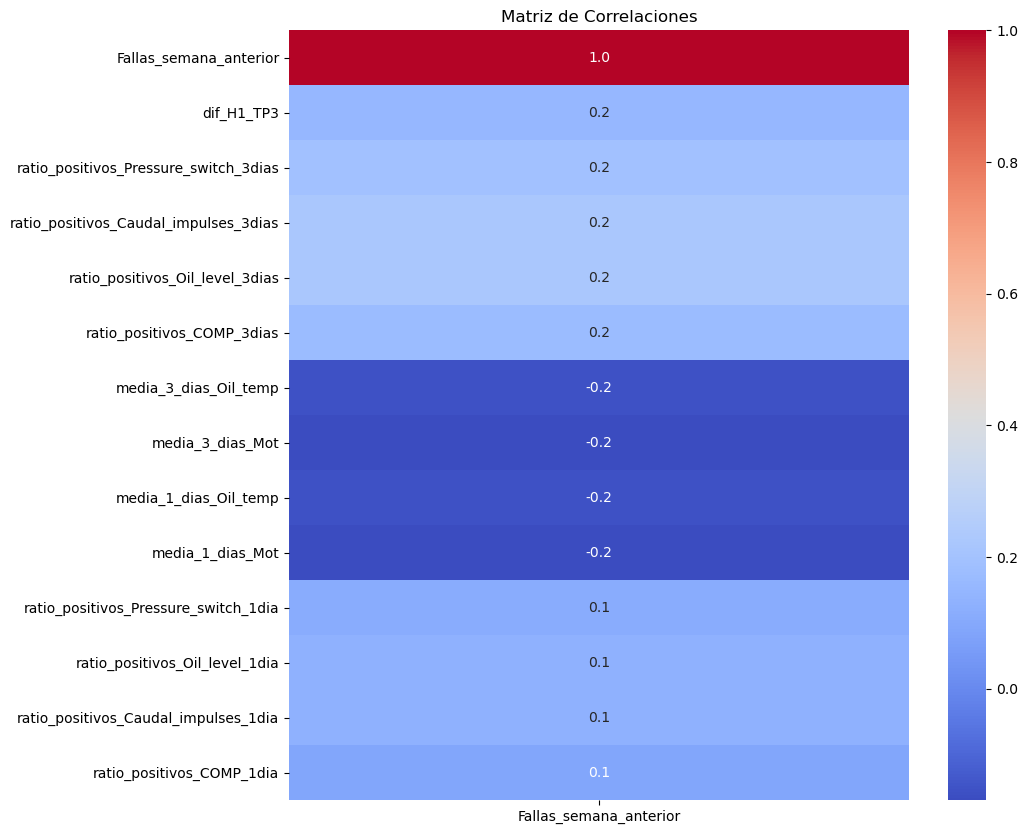

In [62]:
matriz_correlaciones = df_filtrado[['Fallas_semana_anterior', 'dif_H1_TP3',
       'ratio_positivos_Pressure_switch_3dias',
       'ratio_positivos_Caudal_impulses_3dias',
       'ratio_positivos_Oil_level_3dias', 'ratio_positivos_COMP_3dias',
       'media_3_dias_Oil_temp', 'media_3_dias_Mot', 'media_1_dias_Oil_temp',
       'media_1_dias_Mot', 'ratio_positivos_Pressure_switch_1dia',
       'ratio_positivos_Oil_level_1dia',
       'ratio_positivos_Caudal_impulses_1dia', 'ratio_positivos_COMP_1dia']].corr()
primera_columna = matriz_correlaciones[['Fallas_semana_anterior']]
# Creamos un heatmap utilizando Seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(primera_columna, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Matriz de Correlaciones')
plt.show()

### Achicamos el dataset tomando 2 semanas antes de cada falla para poder procesar los modelos, de lo contrario tarda mucho tiempo.

In [141]:
fecha_fallas=fallas["Start Time"]

# Filtrar los registros que están dentro de las dos semanas antes de cada una de esas tres fallas
filtro = filtro_fallas(merged_df,fecha_fallas,weeks=2)
df_filtrado = merged_df[filtro]

### Separamos en Train y Test. Dejamos la última falla afuera del entrenamiento para no sobreajustar el modelo. La idea es que no haya información de la falla. Por eso utilizamos una fecha de corte que no incluya esta falla. El dataset esta ordenado por tiempo.

In [142]:
fallas

,Failure Number,Start Time,End Time,Failure Type,Severity,Report
0,1,2020-04-18,2020-04-18,Air leak,High Stress,NaN
1,2,2020-05-29,2020-05-30,Air leak,High Stress,Maintenance on 4/30/2020 12:00
2,3,2020-06-05,2020-06-07,Air leak,High Stress,Maintenance on 6/08/2020 16:00
3,4,2020-07-15,2020-07-15,Air leak,High Stress,Maintenance on 7/16/2020 00:00


In [143]:
split_date = '2020-06-08'
split_date = pd.to_datetime(split_date)
df_after_split = merged_df.loc[merged_df.timestamp >= split_date]


### Separamos el dataset manualmente en train y test usando la fecha de corte de la linea de arriba.

In [144]:
X_train =df_filtrado.drop(columns=["timestamp","TP3","LPS","Towers","Fallas_semana_anterior","MPG","Fallas_dia_falla"])
X_test=df_after_split.drop(columns=["timestamp","TP3","LPS","Towers","Fallas_semana_anterior","MPG","Fallas_dia_falla"])
y_train = df_filtrado.Fallas_semana_anterior
y_test=df_after_split.Fallas_semana_anterior

### Generamos dos pipes para el preprocesamiento.

In [145]:
numerical_pipe=numerical_columns_pipe(X_train.drop(columns=['Caudal_impulses', 'Pressure_switch', 'COMP', 'Oil_level']))
categorical_pipe=categorical_columns_pipe(['Caudal_impulses', 'Pressure_switch', 'COMP', 'Oil_level'])


### Prueba de modelos de Regresión Logística con randomized search usando pipelines para preprocesamiento. Los resultados no son alentadores.

In [164]:
# Definir los parámetros de búsqueda
params = {
    'C': [1, 10, 100, 1000],
     'penalty': ['l1', 'l2',],
     'solver': ['saga']}
modelo_con_pipe(X_train,X_test,y_train,y_test,"LR",LogisticRegression(),numerical_pipe,categorical_pipe,params)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\manue\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best score: 0.679
Best parameters set:
	 C: 1000
	 penalty: 'l1'
	 solver: 'saga'
              precision    recall  f1-score   support

           0       0.95      0.97      0.96    579807
           1       0.00      0.00      0.00     29016

    accuracy                           0.93    608823
   macro avg       0.48      0.49      0.48    608823
weighted avg       0.91      0.93      0.92    608823

Matriz de Confusión: 
[[565246  14561]
 [ 29004     12]]
Accuracy=  0.9284438991299606


LogisticRegression(C=1000, penalty='l1', solver='saga')

### <u>RandomForest</u>. A simple vista los resultados no son alentadores. Pero no tenemos que perder de vista el objetivo, que es determinar la fecha de falla. Si cada dia tiene aproximadamente 4000 registros (un registro cada 10 segundos), y si logramos minimizar los errores, con asegurar algunos pocos verdaderos positivos podriamos tener predicciones de días correctas. 

In [149]:
params = {
    "n_estimators": [50, 100],    # Number of trees in the forest.
    "max_depth": [None, 10, 20],   # Maximum depth of the trees.
    "min_samples_split": [2, 5, 10],   # Minimum number of samples required to split an internal node.
    "min_samples_leaf": [1, 2, 4],     # Minimum number of samples required to be at a leaf node.

}

modelo_randomized_RF=modelos_ensamble(X_train,X_test,y_train,y_test,RandomForestClassifier(),params)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\manue\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\manue\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\manue\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "C:\Users\manue\anaconda3\envs\dhdsblend2021\lib\site-packages\joblib\parallel.py", line 1088, in __call__
    while self.dispat

Best score: 0.779
Best parameters set:
	 max_depth: 20
	 min_samples_leaf: 1
	 min_samples_split: 10
	 n_estimators: 50
              precision    recall  f1-score   support

           0       0.97      0.82      0.89    579807
           1       0.14      0.56      0.22     29016

    accuracy                           0.81    608823
   macro avg       0.56      0.69      0.56    608823
weighted avg       0.93      0.81      0.86    608823

Matriz de Confusión: 
[[477720 102087]
 [ 12867  16149]]
Accuracy=  0.8111865024810166


In [150]:
y_pred_RF,cm_RF=modificar_threshold(modelo_randomized_RF, X_test,y_test, threshold=0.95)

Matriz de confusión
[[579786     21]
 [ 28814    202]]
Reporte de clasificación
              precision    recall  f1-score   support

           0       0.95      1.00      0.98    579807
           1       0.91      0.01      0.01     29016

    accuracy                           0.95    608823
   macro avg       0.93      0.50      0.49    608823
weighted avg       0.95      0.95      0.93    608823



### Vemos que mejoro notablemente la precisión. Analicemos los verdaderos positivos para ver que fechas nos traen. Usamos "df_after_split" que es el equivalente X_test con la columna Timestamp.

In [151]:
indices_positivos = np.where(y_pred_RF == 1)[0]
registros_positivos = df_after_split.iloc[indices_positivos]
registros_positivos.timestamp.value_counts().head()

2020-07-14    185
2020-07-13     17
2020-08-06     10
2020-07-18      7
2020-07-26      2
Name: timestamp, dtype: int64

### Vemos diferencias notables entre el segundo y tercer registro. Tomamos las dos primeras fechas, las ordenamos de mayor a menor y le sumamos un día. Le sumamos un día porque nuestra variable objetivo esta definida a partir de un día anterior a la falla, hasta 5.

In [152]:
registros_positivos.timestamp.value_counts()[0:2].sort_values(ascending=False)

2020-07-14    185
2020-07-13     17
Name: timestamp, dtype: int64

In [153]:
registros_ordenados=registros_positivos.timestamp.value_counts()[0:2].sort_values(ascending=False)

In [154]:
print(f'El tren fallará el día {registros_ordenados.index[0].date() + timedelta(days=1)} por una pérdida de aire en algún lugar del circuito neumático.')

El tren fallará el día 2020-07-15 por una pérdida de aire en algún lugar del circuito neumático.


### La fecha coincide con el "Start Time" de la falla número 4, que era la que queríamos predecir, y que no incluimos en el set de entrenamiento.

In [155]:
fallas.loc[3,:]

Failure Number                                 4
Start Time                   2020-07-15 00:00:00
End Time                     2020-07-15 00:00:00
Failure Type                            Air leak
Severity                             High Stress
Report            Maintenance on 7/16/2020 00:00
Name: 3, dtype: object

### Modelo <u>Light boost</u>. Veamos si obtenemos los mismos resultados.

In [161]:
params = {  
    "n_estimators": [100,500,700],      
    "max_depth": [2,3,4],            
    "learning_rate": [0.01,0.1],
    
}
modelo_light_boost=modelos_ensamble(X_train,X_test,y_train,y_test,lgb.LGBMClassifier(),params)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best score: 0.853
Best parameters set:
	 learning_rate: 0.1
	 max_depth: 4
	 n_estimators: 500
              precision    recall  f1-score   support

           0       0.96      0.63      0.76    579807
           1       0.06      0.51      0.11     29016

    accuracy                           0.63    608823
   macro avg       0.51      0.57      0.44    608823
weighted avg       0.92      0.63      0.73    608823

Matriz de Confusión: 
[[366410 213397]
 [ 14269  14747]]
Accuracy=  0.6260555202415152


In [162]:
y_pred_lb,cm_LB=modificar_threshold(modelo_light_boost, X_test,y_test, threshold=0.95)

Matriz de confusión
[[521560  58247]
 [ 26850   2166]]
Reporte de clasificación
              precision    recall  f1-score   support

           0       0.95      0.90      0.92    579807
           1       0.04      0.07      0.05     29016

    accuracy                           0.86    608823
   macro avg       0.49      0.49      0.49    608823
weighted avg       0.91      0.86      0.88    608823



In [163]:
predecir_falla(y_pred_lb,df_after_split)

El tren fallará el día 2020-06-17 por una pérdida de aire en algún lugar del circuito neumático.


### También acierta en la predicción pero con una precisión del 78%.

### XGBoost

In [81]:
params = {  
    "n_estimators": [50,100,500],      
    "max_depth": [1,2,3,4],           
    "learning_rate": [0.01, 0.1],      
}
modelo_xg_boost=modelos_ensamble(X_train,X_test,y_train,y_test,XGBClassifier(),params)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


MemoryError: Unable to allocate 2.24 MiB for an array with shape (293725,) and data type int64

In [331]:
y_pred_xg,cm_xg=modificar_threshold(modelo_xg_boost, X_test,y_test, threshold=0.70)

Matriz de confusión
[[568121  11686]
 [ 28892    124]]
Reporte de clasificación
              precision    recall  f1-score   support

           0       0.95      0.98      0.97    579807
           1       0.01      0.00      0.01     29016

    accuracy                           0.93    608823
   macro avg       0.48      0.49      0.49    608823
weighted avg       0.91      0.93      0.92    608823



In [282]:
predecir_falla(y_pred_xg,df_after_split)

El tren fallará el día 2020-06-25 por una pérdida de aire en algún lugar del circuito neumático.


### Descartamos este modelo, no tiene buena precisión con ningun threshold.

### Gradient Boosting

In [272]:

params_gb = {'n_estimators':[200,500, 1000] , 
             'learning_rate':[0.0001,0.001, 0.1],
            'max_depth' : [1,2,3, 4]}

modelo_gb_boost=modelos_ensamble(X_train,X_test,y_train,y_test,GradientBoostingClassifier(),params)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best score: 0.741
Best parameters set:
	 learning_rate: 0.1
	 max_depth: 3
	 n_estimators: 500
              precision    recall  f1-score   support

           0       0.96      0.90      0.93    579807
           1       0.13      0.29      0.18     29016

    accuracy                           0.88    608823
   macro avg       0.55      0.60      0.56    608823
weighted avg       0.92      0.88      0.90    608823

Matriz de Confusión: 
[[524369  55438]
 [ 20549   8467]]
Accuracy=  0.8751903262524576


In [326]:
y_pred_gb,cm_gb=modificar_threshold(modelo_gb_boost, X_test,y_test, threshold=0.95)

Matriz de confusión
[[579757     50]
 [ 28969     47]]
Reporte de clasificación
              precision    recall  f1-score   support

           0       0.95      1.00      0.98    579807
           1       0.48      0.00      0.00     29016

    accuracy                           0.95    608823
   macro avg       0.72      0.50      0.49    608823
weighted avg       0.93      0.95      0.93    608823



In [332]:
predecir_falla(y_pred_gb,df_after_split)

El tren fallará el día 2020-08-07 por una pérdida de aire en algún lugar del circuito neumático.


### La predicción es incorrecta.

### Extra Trees Clasifier

In [289]:
params = {
    "n_estimators": [50, 100,200],    # Number of trees in the forest.
    "max_depth": [None, 10, 20],   # Maximum depth of the trees.
    "min_samples_split": [2, 5, 10],   # Minimum number of samples required to split an internal node.
    "min_samples_leaf": [1, 2, 4],     # Minimum number of samples required to be at a leaf node.

}

modelo_ETC_boost=modelos_ensamble(X_train,X_test,y_train,y_test,ExtraTreesClassifier(),params)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best score: 0.721
Best parameters set:
	 max_depth: 20
	 min_samples_leaf: 2
	 min_samples_split: 2
	 n_estimators: 50
              precision    recall  f1-score   support

           0       0.95      0.97      0.96    579807
           1       0.09      0.06      0.07     29016

    accuracy                           0.93    608823
   macro avg       0.52      0.52      0.52    608823
weighted avg       0.91      0.93      0.92    608823

Matriz de Confusión: 
[[563324  16483]
 [ 27309   1707]]
Accuracy=  0.9280710485641969


In [342]:
y_pred_ETC,cm_ETC=modificar_threshold(modelo_ETC_boost, X_test,y_test, threshold=0.95)

Matriz de confusión
[[576048   3759]
 [ 29016      0]]
Reporte de clasificación
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    579807
           1       0.00      0.00      0.00     29016

    accuracy                           0.95    608823
   macro avg       0.48      0.50      0.49    608823
weighted avg       0.91      0.95      0.93    608823



#### El modelo no arroja resultados correctos cuando se modifica el threshold. Precisión=0%

## Analizamos la feature importance

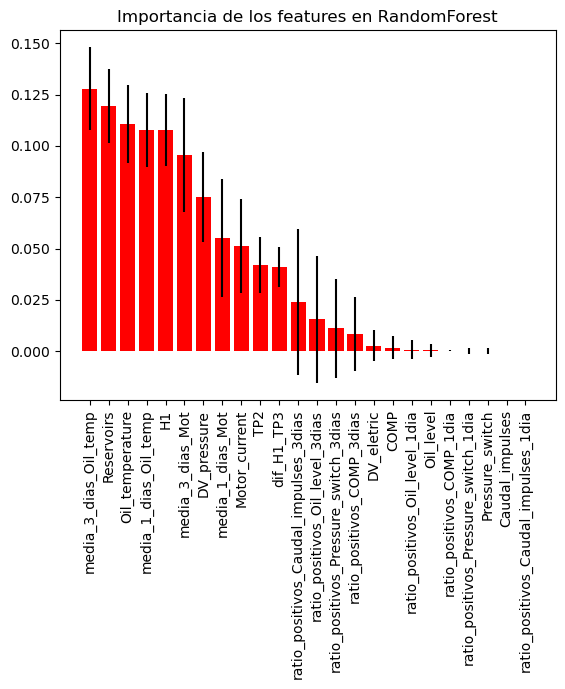

In [353]:
feature_importance (modelo_randomized_RF,X_train)

### Podemos decir que la mayor proporción de reducción de impureza se le atribuye la variable transformada que tiene la media movil de la temperatura del aceite mirando 3 días hacia atras.

## Conclusiones y observaciones.

- El modelo permite anticiparse a este tipo de fallas ocasionadas por pérdidas de aire. De esta manera se pueden evitar interrupciones en el servicio, mejorar la vida util de los equipos y disminuir los costos de mantenimiento reactivo.
- Todos las métricas de los modelos devuelven pesimos valores en terminos de eficiencia. Sin embargo, no hay que perder de vista el objetivo del problema, que es predecir una falla. Si ajustamos los umbrales de decisión para aumentar la precisión, los resultados para el modelo de Random Forests y Light Boosting son acertados.
- Comparando los valores de precisión con umbrales modificados nos quedamos con Random Forests. La precisión es de 97% de RF contra 78% de Light boosting.
- El modelo puede predecir las fallas ocasionadas por pérdidas de aire si se lo alimenta con información de dos semanas de antiguedad y puede avisar con anticipación de 5 días la rotura inminente.
- Para evitar el sobreajuste es necesario dividir el modelo con una fecha de corte, como si fuera una serie temporal. No debe entrenarse ningún registro de una falla del test porque esto aumenta el sesgo obteniendo un sobreajuste del 100%.


### Por último serializamos el modelo en un archivo pickle.

In [356]:
with open('modelo_randomized_RF.pkl', 'wb') as file:
    pickle.dump(modelo_randomized_RF, file)